In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit

In [5]:
def sigmoid(x, a, b, c):
    return a / (1 + np.exp(-(x - c) / b))

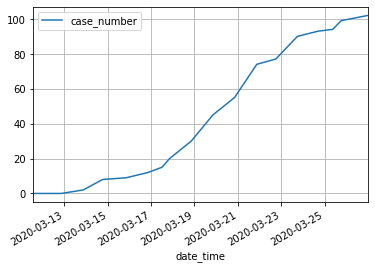

In [3]:
PLACEHOLDER_TIME = "23:59"

df = pd.read_csv("./jena_covid19_scraped.csv").replace({"time": {"None": PLACEHOLDER_TIME}})
df["date_time"] = pd.to_datetime(df["date"] + " " + df["time"])

df.plot(x="date_time", y="case_number")
plt.grid("on")

Let's convert time stamps to the number of days and normalize the variables

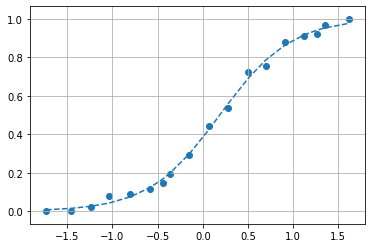

In [9]:
dt = df.date_time - df.date_time[0]
day = np.timedelta64(1, "D")
x = (dt / day).values
y = df.case_number.values.astype(float)

mu_x = x.mean()
sigma_x = x.std()
ymax = y.max()
xn = (x - mu_x) / sigma_x
yn = y / ymax
pn, pcov = curve_fit(sigmoid, xn[:-1], yn[:-1])
ynp = sigmoid(xn, *pn)
plt.scatter(xn, yn, label="Data")
plt.plot(xn, ynp, "--", label="Fit")
plt.grid()

Wow! Now let's rescale back to the days 

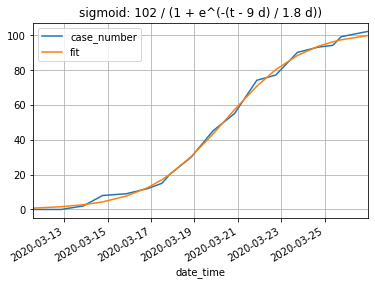

In [10]:
def transform_back(p):
    a = p[0] * ymax
    b = p[1] * sigma_x
    c = p[2] * sigma_x + mu_x
    return a, b, c

p = transform_back(pn)

yp = sigmoid(x, *p)
df["fit"] = yp
df.set_index("date_time").plot()
plt.title(f"sigmoid: {p[0]:.0f} / (1 + e^(-(t - {p[2]:.0f} d) / {p[1]:.1f} d))")
plt.grid("on")

Have no idea how to **properly** rescale the error...

In [8]:
pnerr = np.sqrt(np.diag(pcov))